In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

import data_visualisation as dv
import data_augmentation as da

import models.cnn as cnn
import models.resnet as resnet


2024-05-30 16:34:18.605147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 16:34:19.138949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-30 16:34:19.139039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-30 16:34:19.139051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Augment fns

In [3]:
def augment_ecg_signal(signal,):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# Load Data

In [4]:
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(2159, 100, 12) (2159,)


In [5]:
# smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_resampled_per_fold.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)
print(X_train_resampled.shape, Y_train_resampled.shape)
print(folds_train_resampled.shape)
print(X_test.shape, Y_test.shape)


# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(8386,)
(12544, 100, 12) (12544,)
(12544,)
(2159, 100, 12) (2159,)


# Resnet K-Fold

In [20]:
def k_fold_finetune_resnet(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, freeze_layers=8, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5"):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    layers_to_freeze_substrings = [f"_{i}_" for i in range(1, freeze_layers)]
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_val == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_val[val_index]
        
        print(f"\nTraining on fold {i+1}")
        
        # make model
        out, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
        fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

        # load + freeze weights
        if weights_path:
            fine_tuned_model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
            for layer in fine_tuned_model.layers:
                if any([text in layer.name for text in layers_to_freeze_substrings]):
                    layer.trainable = False
                
        # train
        data_generator = augment_ecg_signal_batch(X_train_fold, Y_train_fold, batch_size=batch_size)
        history = fine_tuned_model.fit(data_generator, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, steps_per_epoch=X_train.shape[0]//batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy, val_precision, val_recall = fine_tuned_model.evaluate(X_val_fold, Y_val_fold, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_val_fold)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        val_auc = roc_auc_score(Y_val_fold, y_pred)
        
        test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_test)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        test_auc = roc_auc_score(Y_test, y_pred)
        
        
        
        print(f"Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
        print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc},Test F1 Score: {test_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            fine_tuned_model.save_weights(f'model-weights/fine-tuned/{name}')
            final_history = history
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)
        
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')   
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"AUC: {np.mean(val_aucs)} \t +/- {np.std(val_aucs)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")
    
    # load best model
    fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
    fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    fine_tuned_model.load_weights('model-weights/resnet10_simclr_model_finetuned_brugada.h5')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    y_pred = fine_tuned_model.predict(X_test)
    test_auc = roc_auc_score(Y_test, y_pred)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
    

# No Pre-training

Training on fold 1
35/35 [==============================] - 0s 4ms/step - loss: 0.2233 - accuracy: 0.9336 - precision: 0.8621 - recall: 0.7919  
Val Accuracy: 0.9335727095603943, Val Precision: 0.8620689511299133, Val Recall: 0.7918552160263062, Val F1 Score: 0.825471698258426
Training on fold 2
33/33 [==============================] - 0s 4ms/step - loss: 0.2594 - accuracy: 0.9335 - precision: 0.9142 - recall: 0.8099      
Val Accuracy: 0.9335232377052307, Val Precision: 0.9141631126403809, Val Recall: 0.8098859190940857, Val F1 Score: 0.8588709706681875
Training on fold 3
34/34 [==============================] - 0s 5ms/step - loss: 0.4054 - accuracy: 0.9064 - precision: 0.8684 - recall: 0.7831      
Val Accuracy: 0.9064272046089172, Val Precision: 0.8684210777282715, Val Recall: 0.7830508351325989, Val F1 Score: 0.8235294162331457
Training on fold 4
31/31 [==============================] - 0s 4ms/step - loss: 0.4533 - accuracy: 0.9215 - precision: 0.9887 - recall: 0.7821  
Val Accurac

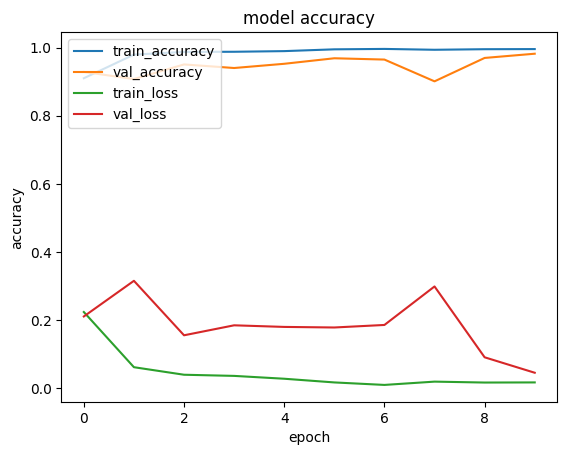

K-Fold Results:
Acuracy: 0.946340948343277 	 +/- 0.02490610963266325
Precision: 0.9011954888701439 	 +/- 0.040992687987244834
Recall: 0.8898598179221153 	 +/- 0.09898823177402029
F1: 0.8918263710896899 	 +/- 0.04984190944633264


68/68 [==============================] - 1s 6ms/step - loss: 0.3028 - accuracy: 0.9449 - precision: 0.8504 - recall: 0.9368   

Test Performance:
Test Accuracy: 0.9448819160461426, Test Precision: 0.8504347801208496, Test Recall: 0.9367815852165222, Test F1 Score: 0.8915223214112487


In [20]:
# no smote
k_fold_finetune_resnet(8, X_train, Y_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1)

Training on fold 1
68/68 [==============================] - 0s 5ms/step - loss: 0.2865 - accuracy: 0.9532 - precision: 0.8623 - recall: 0.9598
Val Accuracy: 0.9667863845825195, Val Precision: 0.8865545988082886, Val Recall: 0.9547511339187622, Val F1 Score: 0.9193899670746098
Test Accuracy: 0.9532190561294556, Test Precision: 0.8623063564300537, Test Recall: 0.959770143032074, Test F1 Score: 0.9084315562959616
Training on fold 2
68/68 [==============================] - 0s 5ms/step - loss: 0.1534 - accuracy: 0.9643 - precision: 0.8870 - recall: 0.9770
Val Accuracy: 0.9439696073532104, Val Precision: 0.9047619104385376, Val Recall: 0.8669201731681824, Val F1 Score: 0.8854369069157046
Test Accuracy: 0.9643353223800659, Test Precision: 0.886956512928009, Test Recall: 0.977011501789093, Test F1 Score: 0.929808567395328
Training on fold 3
68/68 [==============================] - 0s 4ms/step - loss: 0.3954 - accuracy: 0.9602 - precision: 0.8978 - recall: 0.9425
Val Accuracy: 0.915879011154174

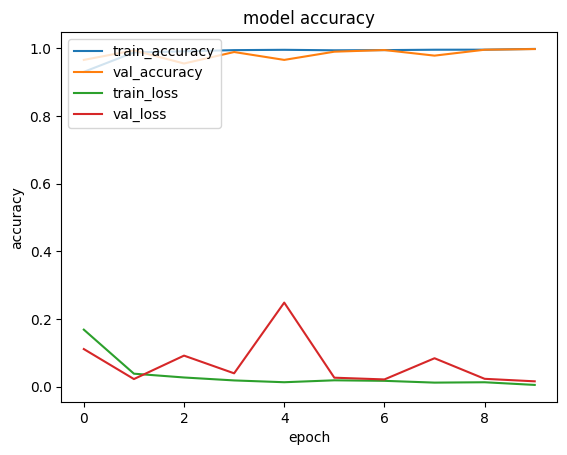

K-Fold Results:
Acuracy: 0.9569881036877632 	 +/- 0.023462766395697558
Precision: 0.9203550964593887 	 +/- 0.05788799671919138
Recall: 0.9165949523448944 	 +/- 0.06242002237951686
F1: 0.9164068106156118 	 +/- 0.04157702575789632


68/68 [==============================] - 1s 5ms/step - loss: 0.1430 - accuracy: 0.9694 - precision: 0.9453 - recall: 0.9272   

Test Performance:
Test Accuracy: 0.9694302678108215, Test Precision: 0.9453125, Test Recall: 0.9272030591964722, Test F1 Score: 0.9361702097394422


In [14]:
# smote
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1)

# SimCLR

Training on fold 1
35/35 [==============================] - 0s 4ms/step - loss: 0.0786 - accuracy: 0.9722 - precision: 0.9398 - recall: 0.9186
Val Accuracy: 0.9721723794937134, Val Precision: 0.9398148059844971, Val Recall: 0.918552041053772, Val F1 Score: 0.9290617830655233
Training on fold 2
33/33 [==============================] - 0s 5ms/step - loss: 0.1830 - accuracy: 0.9649 - precision: 0.9593 - recall: 0.8973  
Val Accuracy: 0.9648622870445251, Val Precision: 0.9593495726585388, Val Recall: 0.8973383903503418, Val F1 Score: 0.9273084314260553
Training on fold 3
34/34 [==============================] - 0s 5ms/step - loss: 0.3265 - accuracy: 0.9452 - precision: 0.8835 - recall: 0.9254      
Val Accuracy: 0.9451795816421509, Val Precision: 0.8834951519966125, Val Recall: 0.9254237413406372, Val F1 Score: 0.9039735192423441
Training on fold 4
31/31 [==============================] - 0s 4ms/step - loss: 0.1988 - accuracy: 0.9607 - precision: 0.9598 - recall: 0.9254
Val Accuracy: 0.960

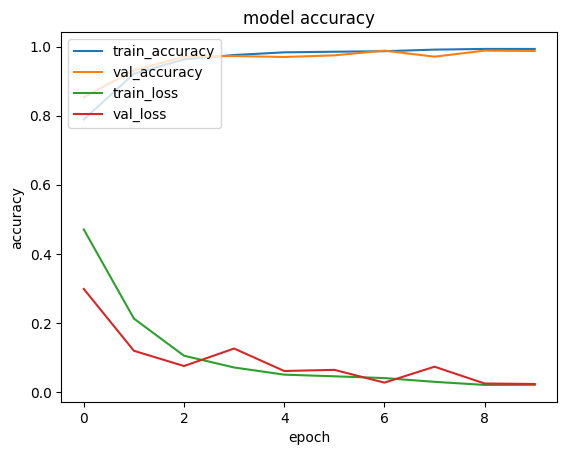

K-Fold Results:
Acuracy: 0.9625810459256172 	 +/- 0.015886924313594158
Precision: 0.9304257556796074 	 +/- 0.03126174809341824
Recall: 0.9204660877585411 	 +/- 0.04611980813717196
F1: 0.9249310518188627 	 +/- 0.033247783804380523


68/68 [==============================] - 1s 5ms/step - loss: 0.1958 - accuracy: 0.9486 - precision: 0.8442 - recall: 0.9655   

Test Performance:
Test Accuracy: 0.9485872983932495, Test Precision: 0.8442211151123047, Test Recall: 0.9655172228813171, Test F1 Score: 0.9008042869497678


In [18]:
# PTB-XL
# No SMOTE
k_fold_finetune_resnet(7, X_train, Y_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)

Training on fold 1


2024-05-30 16:34:40.706959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-30 16:34:40.757950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-30 16:34:40.758157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-30 16:34:40.758626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

68/68 [==============================] - 0s 6ms/step - loss: 0.2036 - accuracy: 0.9546 - precision: 0.9206 - recall: 0.8889  
Val Accuracy: 0.9560143351554871, Val Precision: 0.983146071434021, Val Recall: 0.7918552160263062, Val F1 Score: 0.8771929916678455
Test Accuracy: 0.9546086192131042, Test Precision: 0.920634925365448, Test Recall: 0.8888888955116272, Test F1 Score: 0.904483436510797
Training on fold 2
68/68 [==============================] - 0s 5ms/step - loss: 0.2420 - accuracy: 0.9546 - precision: 0.9435 - recall: 0.8640  
Val Accuracy: 0.9525166153907776, Val Precision: 0.9819004535675049, Val Recall: 0.8250950574874878, Val F1 Score: 0.8966942155935604
Test Accuracy: 0.9546086192131042, Test Precision: 0.9435146450996399, Test Recall: 0.8639847040176392, Test F1 Score: 0.9020000165209767
Training on fold 3
68/68 [==============================] - 0s 5ms/step - loss: 0.1767 - accuracy: 0.9523 - precision: 0.8748 - recall: 0.9368   
Val Accuracy: 0.9574669003486633, Val Prec

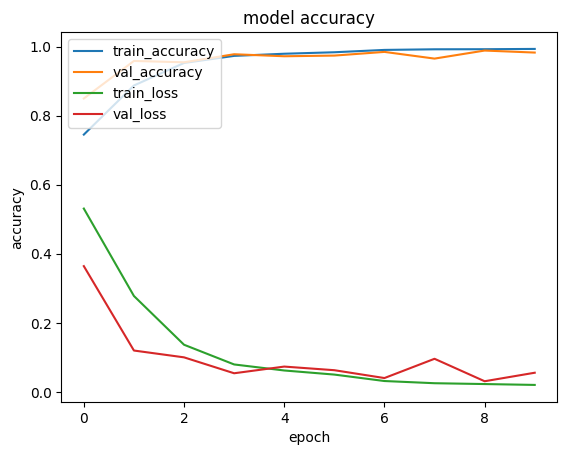

K-Fold Results:
Acuracy: 0.9617714360356331 	 +/- 0.00934016764046423
Precision: 0.9377129152417183 	 +/- 0.03314681096355197
Recall: 0.9104659929871559 	 +/- 0.0667128248018093
F1: 0.921306486318584 	 +/- 0.023705588199462235


68/68 [==============================] - 1s 5ms/step - loss: 0.2616 - accuracy: 0.9504 - precision: 0.8476 - recall: 0.9693   

Test Performance:
Test Accuracy: 0.950439989566803, Test Precision: 0.8475711941719055, Test Recall: 0.969348669052124, Test F1 Score: 0.9043789168990467


In [7]:
# BARD
# NO SMOTE
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9694793820381165, Val Precision: 0.9746192693710327, Val Recall: 0.8687782883644104, Val AUC: 0.9978160960309699, Val F1 Score: 0.9186602825831204
Test Accuracy: 0.9638721346855164, Test Precision: 0.9051094651222229, Test Recall: 0.9501915574073792, Test AUC: 0.9950392854885936,Test F1 Score: 0.9271027847718688

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.94017094373703, Val Precision: 0.8472222089767456, Val Recall: 0.927756667137146, Val AUC: 0.9889926360879819, Val F1 Score: 0.8856624306940781
Test Accuracy: 0.9518295526504517, Test Precision: 0.857876718044281, Test Recall: 0.959770143032074, Test AUC: 0.9872863405397688,Test F1 Score: 0.9059674659726527

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9413988590240479, Val Precision: 0.95686274766922, Val Recall: 0.8271186351776123, Val AUC: 0.9691094475420396

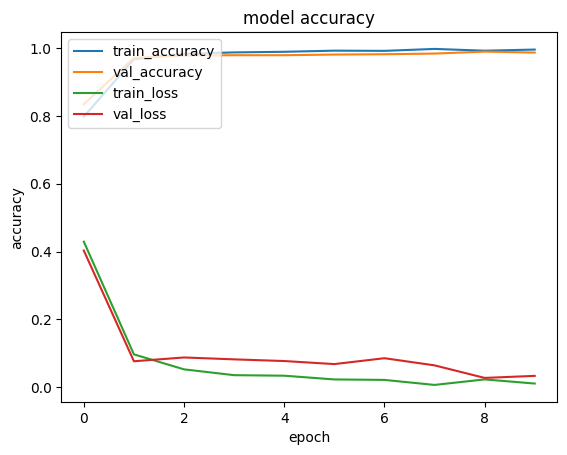

K-Fold Results:
Acuracy: 0.9608869254589081 	 +/- 0.019153274190385493
Precision: 0.9509717524051666 	 +/- 0.04317763465374885
Recall: 0.8959211781620979 	 +/- 0.04839096331079977
AUC: 0.9843275123049443 	 +/- 0.012465602696666463
F1: 0.9214512453032185 	 +/- 0.03382350672355207


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.960629940032959, Test Precision: 0.9309664964675903, Test Recall: 0.9042145609855652, Test AUC: 0.9871938903283035, Test F1 Score: 0.9173955435916975


In [14]:
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=7, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0003, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9605026841163635, Val Precision: 0.9004524946212769, Val Recall: 0.9004524946212769, Val AUC: 0.9936712388461285, Val F1 Score: 0.9004524946212769
Test Accuracy: 0.9495136737823486, Test Precision: 0.8494077920913696, Test Recall: 0.961685836315155, Test AUC: 0.9833490147616072,Test F1 Score: 0.9020664973888827

Training on fold 2
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9278252720832825, Val Precision: 0.8303886651992798, Val Recall: 0.8935361504554749, Val AUC: 0.9739615921451605, Val F1 Score: 0.8608058594506818
Test Accuracy: 0.9550718069076538, Test Precision: 0.867012083530426, Test Recall: 0.961685836315155, Test AUC: 0.9863665194484819,Test F1 Score: 0.911898276469533

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9395084977149963, Val Precision: 0.8888888955116272, Val Recall: 0.8949152827262878, Val AUC: 0.9619832507719

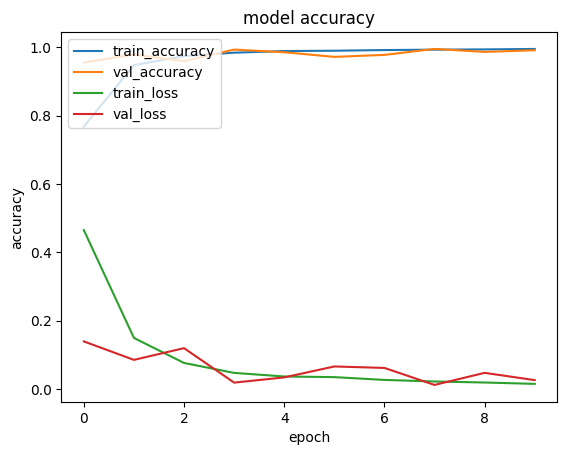

K-Fold Results:
Acuracy: 0.9540170356631279 	 +/- 0.02070510891786806
Precision: 0.9053485244512558 	 +/- 0.042582010462747524
Recall: 0.9131535887718201 	 +/- 0.0674687719816852
AUC: 0.9856975296430306 	 +/- 0.013839340507715701
F1: 0.907859245666982 	 +/- 0.0450160110654207


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.966651201248169, Test Precision: 0.8892733454704285, Test Recall: 0.984674334526062, Test AUC: 0.9889481038344603, Test F1 Score: 0.9345454507721357


In [15]:
# SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9730700254440308, Val Precision: 0.9321267008781433, Val Recall: 0.9321267008781433, Val AUC: 0.9954801801847452, Val F1 Score: 0.9321267008781433
Test Accuracy: 0.9448819160461426, Test Precision: 0.8386554718017578, Test Recall: 0.9559386968612671, Test AUC: 0.9774860329965337,Test F1 Score: 0.8934646426796466

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9439696073532104, Val Precision: 0.8777777552604675, Val Recall: 0.9011406898498535, Val AUC: 0.9773932714058815, Val F1 Score: 0.889305807227401
Test Accuracy: 0.9462714195251465, Test Precision: 0.8274193406105042, Test Recall: 0.982758641242981, Test AUC: 0.9800775645571635,Test F1 Score: 0.8984238180644919

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9413988590240479, Val Precision: 0.8794788122177124, Val Recall: 0.9152542352676392, Val AUC: 0.96089921585

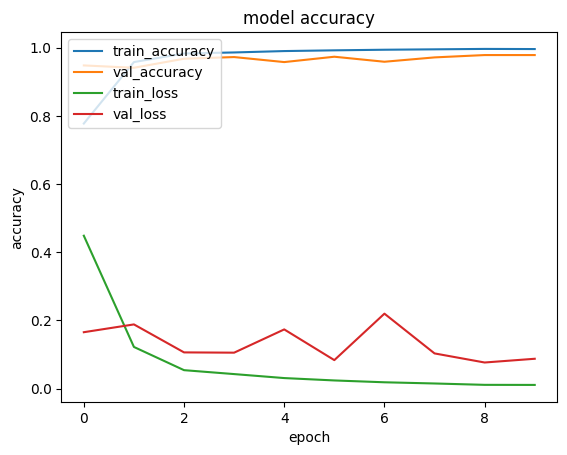

K-Fold Results:
Acuracy: 0.9564163684844971 	 +/- 0.014633546105888596
Precision: 0.9111796393990517 	 +/- 0.044727272706775574
Recall: 0.9179079979658127 	 +/- 0.060474228140907034
AUC: 0.9839292242470787 	 +/- 0.012683247435261585
F1: 0.912526120276388 	 +/- 0.03153274408421686


68/68 [==============================] - 1s 3ms/step

Test Performance:
Test Accuracy: 0.9624826312065125, Test Precision: 0.8916518688201904, Test Recall: 0.961685836315155, Test AUC: 0.9883846256468589, Test F1 Score: 0.9253456299867325


In [16]:
# SMOTE
# BARD
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)

# MoCo v2

Training on fold 1
35/35 [==============================] - 0s 4ms/step - loss: 0.2054 - accuracy: 0.9488 - precision: 0.8178 - recall: 0.9548
Val Accuracy: 0.9488330483436584, Val Precision: 0.817829430103302, Val Recall: 0.9547511339187622, Val F1 Score: 0.8810020730133012
Training on fold 2
33/33 [==============================] - 0s 5ms/step - loss: 0.3790 - accuracy: 0.9316 - precision: 0.9283 - recall: 0.7871      
Val Accuracy: 0.9316239356994629, Val Precision: 0.9282511472702026, Val Recall: 0.7870722413063049, Val F1 Score: 0.851851861687037
Training on fold 3
34/34 [==============================] - 0s 4ms/step - loss: 0.5088 - accuracy: 0.9045 - precision: 0.8415 - recall: 0.8102  
Val Accuracy: 0.9045368432998657, Val Precision: 0.841549277305603, Val Recall: 0.810169517993927, Val F1 Score: 0.8255613174628528
Training on fold 4
31/31 [==============================] - 0s 4ms/step - loss: 0.4578 - accuracy: 0.9122 - precision: 0.9281 - recall: 0.8090  
Val Accuracy: 0.9121

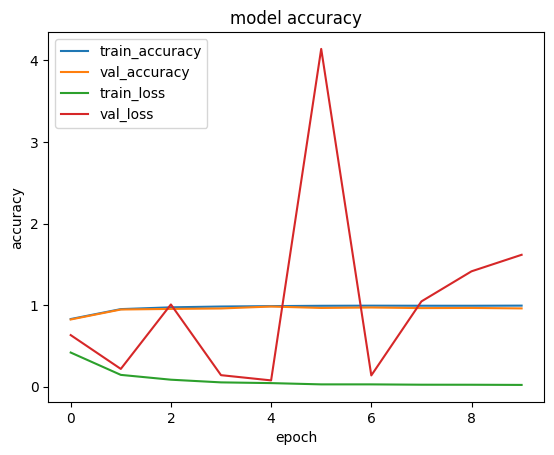

K-Fold Results:
Acuracy: 0.9405498504638672 	 +/- 0.020500163763900917
Precision: 0.8851517513394356 	 +/- 0.06000868404512675
Recall: 0.8891489654779434 	 +/- 0.08419989259591185
F1: 0.8823801259625019 	 +/- 0.03234596361880924


68/68 [==============================] - 1s 5ms/step - loss: 0.2228 - accuracy: 0.9504 - precision: 0.8547 - recall: 0.9579

Test Performance:
Test Accuracy: 0.950439989566803, Test Precision: 0.8547008633613586, Test Recall: 0.9578543901443481, Test F1 Score: 0.9033423644850719


In [22]:
# NO SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train, Y_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1)

In [ ]:
# NO SMOTE
# BARD

## TODO: pretrain a model on the BARD dataset
# k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9802513718605042, Val Precision: 0.9383260011672974, Val Recall: 0.9638009071350098, Val AUC: 0.9971117743333012, Val F1 Score: 0.950892863316433
Test Accuracy: 0.9564613103866577, Test Precision: 0.8702422380447388, Test Recall: 0.9636015295982361, Test AUC: 0.9890230002083056,Test F1 Score: 0.9145454661917093

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9420702457427979, Val Precision: 0.9316239356994629, Val Recall: 0.8288973569869995, Val AUC: 0.9437647398565723, Val F1 Score: 0.8772635937038209
Test Accuracy: 0.9675775766372681, Test Precision: 0.9139193892478943, Test Recall: 0.9559386968612671, Test AUC: 0.993957383963282,Test F1 Score: 0.934456915724324

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9177693724632263, Val Precision: 0.8270440101623535, Val Recall: 0.8915254473686218, Val AUC: 0.972979096785

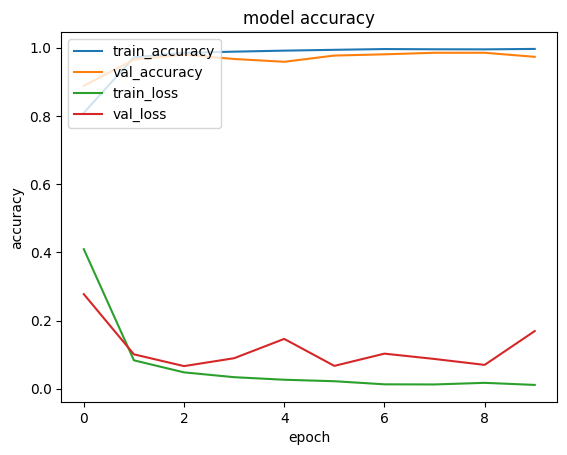

K-Fold Results:
Acuracy: 0.9534400701522827 	 +/- 0.020120794818621678
Precision: 0.895521953701973 	 +/- 0.052302830734009556
Recall: 0.9277016520500183 	 +/- 0.04636124023895939
AUC: 0.983462003345432 	 +/- 0.01736594515023358
F1: 0.9098423875644978 	 +/- 0.034288208131423095


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9624826312065125, Test Precision: 0.8916518688201904, Test Recall: 0.961685836315155, Test AUC: 0.9883846256468589, Test F1 Score: 0.9253456299867325


In [22]:
# SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1, name="moco_bard_no_smote.h5")

In [ ]:
# SMOTE
# BARD

## TODO: pretrain a model on the BARD dataset
# k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='models/test_moco_model.h5', learning_rate=0.0005, num_classes=1)

# Auto-Encoder

In [ ]:
def encoder(inputs, latent_dim):
    # 100 x 12
    X = layers.Conv1D(24, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv1')(inputs)
    # 96 x 24
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 48 x 32
    X = layers.Conv1D(48, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv2')(X)
    # 44 x 48
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 22 x 48
    X = layers.Conv1D(64, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv3')(X)
    # 18 x 64
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 9 x 64
    X = layers.Flatten()(X)
    # 1152
    X = layers.Dense(latent_dim, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense-encode')(X)
    # latent_dim
    return X

def decoder(latent_rep, latent_dim):
    X = layers.Dense(9*64, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense-decode')(latent_rep)
    # 1152
    X = layers.Reshape((9, 64))(X)
    # 9 x 64
    X = layers.UpSampling1D(2)(X)
    # 18 x 64
    X = layers.Conv1DTranspose(48, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='upconv1')(X)
    # 22 x 48
    X = layers.UpSampling1D(2)(X)
    # 44 x 48
    X = layers.Conv1DTranspose(24, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='upconv2')(X)
    # 48 x 24
    X = layers.UpSampling1D(2)(X)
    # 96 x 24
    X = layers.Conv1DTranspose(12, 5, activation='linear', padding='valid', name='upconv3')(X)
    # 100 x 12
    return X

def make_model(inputs, latent_dim):
    latent_rep = encoder(inputs, latent_dim)
    X = decoder(latent_rep, latent_dim)
    return keras.Model(inputs=inputs, outputs=X)

In [ ]:
def classification_head(inputs, num_classes):
    X = layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense1')(inputs)
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense2')(X)
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(num_classes, activation='sigmoid', name='dense3')(X)
    return X

In [ ]:
def k_fold_autoencoder_classification(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5"):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_val == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_val[val_index]
        
        print(f"\nTraining on fold {i+1}")
        
        # make model
        enc = encoder(X_input, 256)
        classiifier = classification_head(enc, 1)
        model = keras.Model(inputs=inputs, outputs=classiifier)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

        # load + freeze weights
        if weights_path:
            model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
                
        # train
        history = model.fit(X_train_fold, X_train_fold, validation_data=(X_val_fold, X_val_fold), epochs=epochs, batch_size=batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy = model.evaluate(X_val_fold, X_val_fold, batch_size=32, verbose=0)
        y_pred = model.predict(X_val_fold)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        val_auc = roc_auc_score(Y_val_fold, y_pred)
        
        test_loss, test_accuracy = model.evaluate(X_test, X_test, batch_size=32, verbose=0)
        y_pred = model.predict(X_test)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        test_auc = roc_auc_score(Y_test, y_pred)
        
        print(f"Val Accuracy: {val_accuracy}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
        print(f"Test Accuracy: {test_accuracy}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            model.save_weights(f'model-weights/fine-tuned/{name}')
            final_history = history
            
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"AUC: {np.mean(val_aucs)} \t +/- {np.std(val_aucs)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")

    # load best model
    enc = encoder(X_input, 256)
    classiifier = classification_head(enc, 1)
    model = keras.Model(inputs=inputs, outputs=classiifier)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    model.load_weights('model-weights/resnet10_simclr_model_finetuned_brugada.h5')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy = model.evaluate(X_test, X_test, batch_size=32)
    y_pred = model.predict(X_test)
    test_auc = roc_auc_score(Y_test, y_pred)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
    
    